# Extract Features

This tutorials present a step-by-step set of instructions on how to extract a set of *Radiomics* from a specified DCE-MRI and its corresponding tumor mask.

In addition, we present a set of instructions to extract a set of *RadioDynamics* from the same DCE-MRI.

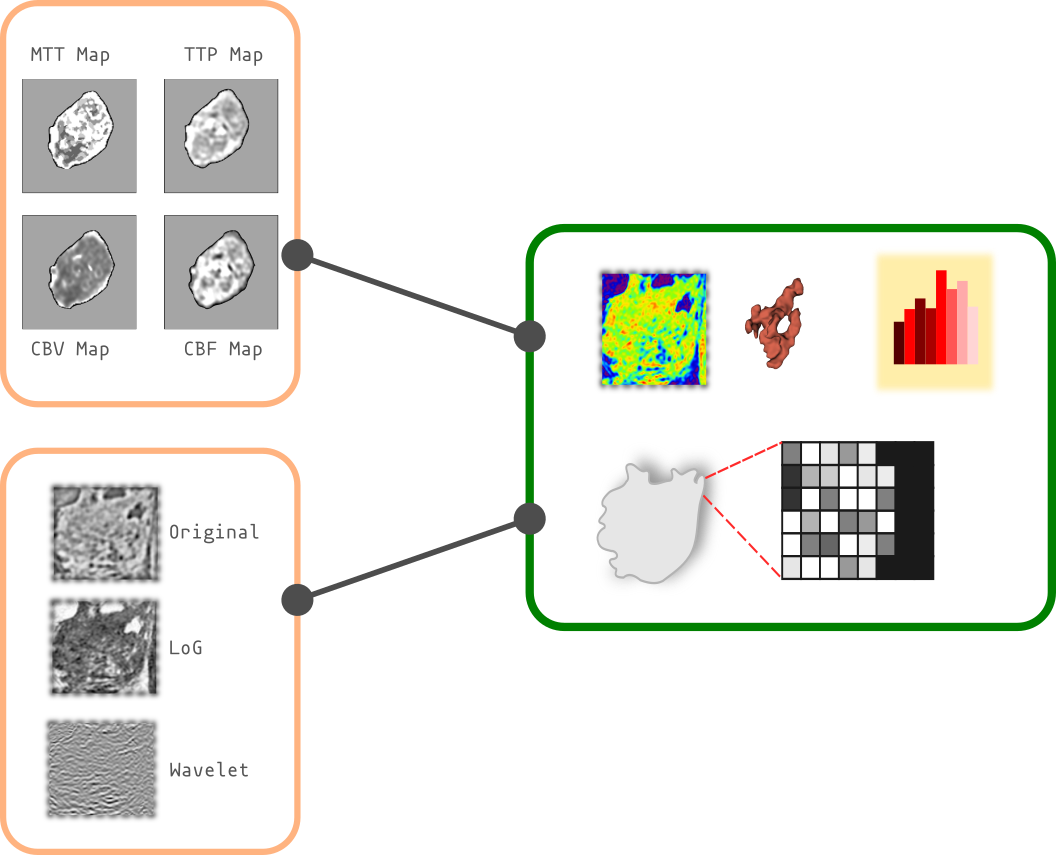

In [1]:
from radiomics import featureextractor
import json
import logging
import yaml
import radiomics
import six
import Hive_ML.configs
radiomics.logger.setLevel(logging.ERROR)
from importlib.resources import as_file, files
from pathlib import Path
import SimpleITK as sitk
import pandas as pd
from Hive_ML.data_loader.image_loader import get_id_label
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set Feature Parameter and Configuration file paths

*feature_param_file* file is used by **pyradiomics** to configure the extractor, while *config_file* contains experiment parameters.

In [2]:
feature_param_file = "radiomic_original_params.yaml"
config_file = "Radiomics_config.json"

try:
    with open(config_file) as json_file:
        config_dict = json.load(json_file)
except FileNotFoundError:
    with as_file(files(Hive_ML.configs).joinpath(config_file)) as json_path:
        with open(json_path) as json_file:
            config_dict = json.load(json_file)

try:
    extractor = featureextractor.RadiomicsFeatureExtractor(feature_param_file)
except:
    with as_file(files(Hive_ML.configs).joinpath(feature_param_file)) as file:
        extractor = featureextractor.RadiomicsFeatureExtractor(str(file))


In [3]:
print(json.dumps(config_dict, indent=2))

{
  "image_suffix": "_cropped.nii.gz",
  "mask_suffix": "_mask.nii.gz",
  "label_dict": {
    "0": "non-pCR",
    "1": "pCR"
  },
  "models": {
    "rf": {
      "criterion": "gini",
      "n_estimators": 100,
      "max_depth": 10
    },
    "adab": {
      "criterion": "gini",
      "n_estimators": 100,
      "max_depth": 10
    },
    "knn": {},
    "lda": {},
    "qda": {},
    "logistic_regression": {},
    "svm": {
      "kernel": "rbf"
    },
    "naive": {}
  },
  "feature_selection": "SFFS",
  "n_features": 30,
  "n_folds": 5,
  "random_seed": 12345,
  "feature_aggregator": "Flat"
}


In [4]:
with open(file, 'r') as stream:
    d=yaml.safe_load(stream)
    print(json.dumps(d, indent=2))

{
  "setting": {
    "binWidth": 80,
    "label": 1,
    "interpolator": "sitkBSpline",
    "resampledPixelSpacing": null,
    "weightingNorm": null
  },
  "imageType": {
    "Original": {}
  },
  "featureClass": {
    "firstorder": [],
    "glcm": [],
    "glrlm": [],
    "glszm": [],
    "gldm": []
  }
}


## Extract Radiomics for one example case

In [5]:
data_folder = "Data/DCE_MRI_dataset"

image_suffix = config_dict["image_suffix"]
mask_suffix = config_dict["mask_suffix"]
patient_class = "pCR"
patient_id = "Patient09"

In [6]:
image_filename = str(Path(data_folder).joinpath(patient_class, patient_id,patient_id+image_suffix))
mask_filename = str(Path(data_folder).joinpath(patient_class,patient_id, patient_id+mask_suffix))

## Load DCE-MRI and Extract Patient ID and PCR Class

In [7]:
img = sitk.ReadImage(image_filename)

subject_ID, label = get_id_label(image_filename, config_dict)

## Generate list of 3D MRI from original DCE-MRI

In [8]:

def get_3D_image_sequence_list_from_4D_image(image_filename):
    itk_image = sitk.ReadImage(image_filename)
    img_array = sitk.GetArrayFromImage(itk_image)

    n_sequence = itk_image.GetSize()[-1]
    direction_3D = itk_image.GetDirection()[:3] + itk_image.GetDirection()[4:7] + itk_image.GetDirection()[8:11]
    origin = itk_image.GetOrigin()[:3]
    spacing = itk_image.GetSpacing()[:3]

    sitk_3D_image_sequences = []
    for sequence in range(n_sequence):
        img_sequence = img_array[sequence]
        itk_img_sequence = sitk.GetImageFromArray(img_sequence)
        itk_img_sequence.SetOrigin(origin)
        itk_img_sequence.SetSpacing(spacing)
        itk_img_sequence.SetDirection(direction_3D)
        sitk_3D_image_sequences.append(itk_img_sequence)

    return sitk_3D_image_sequences

sitk_3D_image_sequence_list = get_3D_image_sequence_list_from_4D_image(image_filename)

## Load and Binarize Tumor Mask

In [9]:
sitk_mask = sitk.ReadImage(mask_filename)
mask_array = sitk.GetArrayFromImage(sitk_mask)
mask_array[mask_array>0] = 1
sitk_mask_thresholded = sitk.GetImageFromArray(mask_array)
sitk_mask_thresholded.CopyInformation(sitk_mask)

## Extract Radiomics

In [10]:
image_types_dict = extractor.enabledImagetypes
image_types = [x.lower() for x in image_types_dict]

radiomics = []
    
for sequence_number, itk_3D_image in enumerate(sitk_3D_image_sequence_list):
    if itk_3D_image is None:
        features_map = {"Subject_ID": subject_ID, "Subject_Label": label, "Sequence_Number": sequence_number}
    else:
        if itk_3D_image.GetSize() != sitk_mask.GetSize():
            continue
        features = extractor.execute(itk_3D_image, sitk_mask_thresholded)
        features_map = {"Subject_ID": subject_ID, "Subject_Label": label, "Sequence_Number": sequence_number}
        for key, val in six.iteritems(features):
            if key.startswith(tuple(image_types)):
                features_map[key] = features[key]
        radiomics.append(features_map)

### Create Pandas DataFrame for extracted radiomics

In [11]:
features_df_radiomics = pd.DataFrame()

for feature_sequence in radiomics:
    features_df_radiomics = features_df_radiomics.append(feature_sequence, ignore_index=True)

In [36]:
features_df_radiomics.iloc[: , :8]

,Subject_ID,Subject_Label,Sequence_Number,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange
0,Patient09,1,0,692.0,958.0,31339233843.0,2.538539177385789,133.0
1,Patient09,1,1,1528.0,3057.0,258953028438.0,4.8843362216775486,815.0
2,Patient09,1,2,1900.0,3525.0,347798310884.0,5.052909316272452,863.0
3,Patient09,1,3,2008.0,3712.0,379877844393.0,5.117595498457545,893.0
4,Patient09,1,4,2108.0,3830.0,405192673015.0,5.119393266339,910.0
5,Patient09,1,5,2072.0,3826.0,398928464859.0,5.1225386994521465,936.0
6,Patient09,1,6,2029.0,3790.0,388117188937.0,5.112674950490647,976.0
7,Patient09,1,7,2096.0,3873.0,406389615214.0,5.101175254871975,1004.0
8,Patient09,1,8,2081.0,3836.0,397835822564.0,5.065126255622619,1018.0


## Load RadioDynamics Configuration

In [17]:
config_file = "Radiodynamics_config.json"

try:
    with open(config_file) as json_file:
        config_dict = json.load(json_file)
except FileNotFoundError:
    with as_file(files(Hive_ML.configs).joinpath(config_file)) as json_path:
        with open(json_path) as json_file:
            config_dict = json.load(json_file)

In [18]:
print(json.dumps(config_dict, indent=2))

{
  "image_suffix": [
    "_ttp_map.nii.gz",
    "_cbv_map.nii.gz",
    "_cbf_map.nii.gz",
    "_mtt_map.nii.gz"
  ],
  "mask_suffix": "_mask.nii.gz",
  "label_dict": {
    "0": "non-pCR",
    "1": "pCR"
  },
  "models": {
    "rf": {
      "criterion": "gini",
      "n_estimators": 100,
      "max_depth": 10
    },
    "adab": {
      "criterion": "gini",
      "n_estimators": 100,
      "max_depth": 10
    },
    "knn": {},
    "lda": {},
    "qda": {},
    "logistic_regression": {},
    "svm": {
      "kernel": "rbf"
    },
    "naive": {}
  },
  "perfusion_maps": {
    "distance_map": "_distance_map.nii.gz",
    "distance_map_depth": {
      "suffix": "_distance_map_depth.nii.gz",
      "kwargs": [
        2
      ]
    },
    "ttp": "_ttp_map.nii.gz",
    "cbv": "_cbv_map.nii.gz",
    "cbf": "_cbf_map.nii.gz",
    "mtt": "_mtt_map.nii.gz"
  },
  "feature_selection": "SFFS",
  "n_features": 30,
  "n_folds": 5,
  "random_seed": 12345,
  "feature_aggregator": "Flat"
}


## Extract Radiodynamics for one example case

In [24]:
data_folder = "Data/DCE_MRI_dataset"

image_suffix = config_dict["image_suffix"]
mask_suffix = config_dict["mask_suffix"]
patient_class = "pCR"
patient_id = "Patient09"

In [30]:
image_filename = [ str(Path(data_folder).joinpath(patient_class, patient_id,patient_id+suffix)) for suffix in image_suffix ]
mask_filename = str(Path(data_folder).joinpath(patient_class,patient_id, patient_id+mask_suffix))

In [31]:
sitk_3D_image_sequence_list = []
for single_image_filename in image_filename:
    img = sitk.ReadImage(single_image_filename)
    sitk_3D_image_sequence_list.append(img)

## Extract Radiodynamics

In [32]:
image_types_dict = extractor.enabledImagetypes
image_types = [x.lower() for x in image_types_dict]

radiodynamics = []
    
for sequence_number, itk_3D_image in enumerate(sitk_3D_image_sequence_list):
    if itk_3D_image is None:
        features_map = {"Subject_ID": subject_ID, "Subject_Label": label, "Sequence_Number": sequence_number}
    else:
        if itk_3D_image.GetSize() != sitk_mask.GetSize():
            continue
        features = extractor.execute(itk_3D_image, sitk_mask_thresholded)
        features_map = {"Subject_ID": subject_ID, "Subject_Label": label, "Sequence_Number": sequence_number}
        for key, val in six.iteritems(features):
            if key.startswith(tuple(image_types)):
                features_map[key] = features[key]
        radiodynamics.append(features_map)

### Create Pandas DataFrame for extracted radiodynamics

In [33]:
features_df_radiodynamics = pd.DataFrame()

for feature_sequence in radiodynamics:
    features_df_radiodynamics = features_df_radiodynamics.append(feature_sequence, ignore_index=True)

In [35]:
features_df_radiodynamics.iloc[:,:8]

,Subject_ID,Subject_Label,Sequence_Number,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange
0,Patient09,1,0,3.0,9.0,1778182.0,-3.203426503814917e-16,4.0
1,Patient09,1,1,17388.0,29499.6,25222434775947.0,7.930424019808104,6377.0
2,Patient09,1,2,779.0,2187.0,115700114255.0,4.756985888997801,751.0
3,Patient09,1,3,11.300631052251624,27.62986663210047,15518190.457845975,0.0003761360014984486,7.2125696336106415
